müşterileri "Premium" ve "Standart" olarak sınıflandırmayı hedefleyen bir veri seti oluşturalım. Bu problem, müşterilerin alışveriş alışkanlıklarına ve demografik bilgilerine dayalı bir sınıflandırma

In [271]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.stats import zscore
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, accuracy_score
from sklearn.decomposition import PCA  # PCA (Principal Component Analysis) için sklearn'dan PCA import ediliyor.
import time

pd.options.display.float_format = '{:.2f}'.format



In [225]:
#df = pd.read_csv('/kaggle/input/musteri-segmentasyonu-database/musteri_segmentasyonu.csv')
df = pd.read_csv('/kaggle/input/musteri-segmentasyonu-database-2/musteri_segmentasyonu.csv')

In [226]:
df.head()

Yaş    Gelir  Alışveriş Skoru  Sadakat Yılı Ürün Tercihi Şikayet Sayısı  \
0 56.00 13343.00               95             5        Giyim            Çok   
1 69.00 23500.00                6             1        Giyim            Yok   
2 46.00 63222.00               66             2        Giyim            Yok   
3 32.00 39375.00               84             4         Gıda            Çok   
4 60.00 19662.00               92            10   Elektronik             Az   

    Segment  
0  Standart  
1  Standart  
2  Standart  
3  Standart  
4  Standart

In [227]:
df.shape

(500, 7)

In [228]:
# Null degerleri belirle ve gerekli işlemleri yap
df.isna().sum()

Yaş                50
Gelir              25
Alışveriş Skoru     0
Sadakat Yılı        0
Ürün Tercihi       75
Şikayet Sayısı      0
Segment             0
dtype: int64

In [229]:
print(df.dtypes)

Yaş                float64
Gelir              float64
Alışveriş Skoru      int64
Sadakat Yılı         int64
Ürün Tercihi        object
Şikayet Sayısı      object
Segment             object
dtype: object


In [230]:
 #Sütunun aldığı tüm benzersiz değerleri görüntüle
yas = df['Yaş'].unique()
print(yas)

[56. 69. 46. 32. 60. 25. nan 36. 40. 28. 41. 53. 57. 20. 39. 19. 61. 47.
 38. 50. 29. 42. 44. 59. 45. 33. 64. 68. 54. 24. 26. 35. 21. 31. 67. 43.
 37. 52. 34. 23. 51. 27. 48. 65. 62. 58. 18. 22. 30. 49. 66. 55. 63.]


In [231]:
 #Sütunun aldığı tüm benzersiz değerleri görüntüle
gelir = df['Gelir'].unique()
print(gelir)

[13343. 23500. 63222. 39375. 19662. 26964. 69638. 83666. 95067. 77215.
 79042. 23284. 82789. 94664.    nan 19435. 64340. 54078. 88832. 61293.
 88781. 70403. 39124. 53919. 45247. 72752. 66573. 69101. 36646. 33049.
 89605. 78385. 50158. 75417. 33289. 19823. 70160. 51975. 19540. 14611.
 37663. 61991. 67679. 40977. 59115. 98223. 70890. 76387. 28071. 69275.
 82369. 21938. 45195. 14000. 80588. 48304. 79449. 92986. 99643. 30764.
 96027. 48494. 13373. 22161. 37350. 35351. 98668. 25305. 85353. 86797.
 75953. 67458. 30358. 13267. 99588. 48513. 36092. 10412. 17543. 43496.
 70692. 99084. 54425. 48756. 28888. 57295. 93042. 95999. 27955. 47841.
 80640. 75510. 44911. 69031. 98726. 17357. 42479. 71476. 54811. 46208.
 30150. 81180. 53286. 78450. 31352. 65069. 24397. 51555. 56959. 10728.
 60517. 76234. 49954. 57280. 89459. 26779. 73932. 82936. 34466. 46939.
 79896. 45270. 69163. 92637. 61934. 74895. 42307. 64098. 70921. 15486.
 18335. 96900. 99112. 21130. 97508. 70566. 76703. 37192. 11062. 94076.
 99780

In [232]:
urun_tercihi = df['Ürün Tercihi'].unique()
print(urun_tercihi)

['Giyim' 'Gıda' 'Elektronik' nan]


In [233]:
sikayet = df['Şikayet Sayısı'].unique()
print(sikayet)

['Çok' 'Yok' 'Az']


In [234]:
segment = df['Segment'].unique()
print(segment)

['Standart' 'Premium']


In [235]:
# 'Segment' sütununu 1 ve 0 olarak kodlama
df['Segment'] = df['Segment'].map({'Standart': 1, 'Premium': 0})

In [236]:
segment = df['Segment'].unique()
print(segment)

[1 0]


In [237]:
df.head()

Yaş    Gelir  Alışveriş Skoru  Sadakat Yılı Ürün Tercihi Şikayet Sayısı  \
0 56.00 13343.00               95             5        Giyim            Çok   
1 69.00 23500.00                6             1        Giyim            Yok   
2 46.00 63222.00               66             2        Giyim            Yok   
3 32.00 39375.00               84             4         Gıda            Çok   
4 60.00 19662.00               92            10   Elektronik             Az   

   Segment  
0        1  
1        1  
2        1  
3        1  
4        1

In [238]:
# 'Şikayet Sayısı' sütununu sıralı kodlama
df['Şikayet Sayısı'] = df['Şikayet Sayısı'].map({'Yok': 0, 'Az': 1, 'Çok': 2})

In [239]:
df.head()

Yaş    Gelir  Alışveriş Skoru  Sadakat Yılı Ürün Tercihi  Şikayet Sayısı  \
0 56.00 13343.00               95             5        Giyim               2   
1 69.00 23500.00                6             1        Giyim               0   
2 46.00 63222.00               66             2        Giyim               0   
3 32.00 39375.00               84             4         Gıda               2   
4 60.00 19662.00               92            10   Elektronik               1   

   Segment  
0        1  
1        1  
2        1  
3        1  
4        1

In [240]:
# Eksik değerleri mod (en sık görülen) ile doldurma
df['Ürün Tercihi'] = df['Ürün Tercihi'].fillna(df['Ürün Tercihi'].mode()[0])

# Alternatif: Eksik değerlere 'Bilinmiyor' ekleme
# df['Ürün Tercihi'] = df['Ürün Tercihi'].fillna('Bilinmiyor')

# One-Hot Encoding ile kategorik veriyi dönüştürme
df = pd.get_dummies(df, columns=['Ürün Tercihi'], prefix='Ürün')

In [241]:
df.head()

Yaş    Gelir  Alışveriş Skoru  Sadakat Yılı  Şikayet Sayısı  Segment  \
0 56.00 13343.00               95             5               2        1   
1 69.00 23500.00                6             1               0        1   
2 46.00 63222.00               66             2               0        1   
3 32.00 39375.00               84             4               2        1   
4 60.00 19662.00               92            10               1        1   

   Ürün_Elektronik  Ürün_Giyim  Ürün_Gıda  
0            False        True      False  
1            False        True      False  
2            False        True      False  
3            False       False       True  
4             True       False      False

In [242]:
 #Sütunun aldığı tüm benzersiz değerleri görüntüle
sadakat_yili = df['Sadakat Yılı'].unique()
print(sadakat_yili)

[ 5  1  2  4 10  0  9  8  6  7  3]


In [243]:


class CustomKNN:
    # __init__ fonksiyonu, modelin başlangıç parametrelerini alır.
    def __init__(self, k=3, metric='euclidean'):
        # k, komşu sayısını belirtir; varsayılan olarak 3.
        # metric, mesafe hesaplama türünü belirtir; varsayılan olarak 'euclidean' seçilmiştir.
        self.k = k
        self.metric = metric

    # fit fonksiyonu, eğitim verilerini alır ve model üzerinde saklar.
    def fit(self, X_train, y_train):
        # X_train, eğitim verilerinin özelliklerini içerir (özellikler).
        # y_train, eğitim verilerinin etiketlerini içerir (sınıflar).
        self.X_train = X_train
        self.y_train = y_train

    # _compute_distance fonksiyonu, iki veri noktası arasındaki mesafeyi hesaplar.
    def _compute_distance(self, x1, x2):
        # Kullanıcı tarafından seçilen mesafe ölçütüne göre mesafeyi hesaplar.
        
        # Eğer mesafe türü 'euclidean' ise, Öklid mesafesi kullanılır.
        if self.metric == 'euclidean':
            # Öklid mesafesi formülü: sqrt( (x1 - x2)^2 )
            return np.sqrt(np.sum((x1 - x2) ** 2))
        
        # Eğer mesafe türü 'manhattan' ise, Manhattan mesafesi kullanılır.
        elif self.metric == 'manhattan':
            # Manhattan mesafesi formülü: |x1 - x2|
            return np.sum(np.abs(x1 - x2))
        
        # Eğer mesafe türü 'minkowski' ise, Minkowski mesafesi kullanılır.
        elif self.metric == 'minkowski':
            # Minkowski mesafesinde p parametresi vardır. Bu örnekte p=3 olarak belirlenmiş.
            p = 3  # Minkowski metrik parametresi, burada 3 olarak alınmıştır.
            # Minkowski mesafesi formülü: (sum(|x1 - x2|^p))^(1/p)
            return np.sum(np.abs(x1 - x2) ** p) ** (1/p)

    # predict fonksiyonu, test verisi için tahminler yapar.
    def predict(self, X_test):
        predictions = []  # Tahminlerin saklanacağı liste

        # Test verisi üzerindeki her bir örnek için tahmin yapılır.
        for x in X_test:
            # Her test örneği için, tüm eğitim örnekleri ile mesafeler hesaplanır.
            distances = [self._compute_distance(x, x_train) for x_train in self.X_train]
            
            # Eğitim verilerinden en yakın k komşusunun indeksleri alınır.
            k_indices = np.argsort(distances)[:self.k]
            
            # Bu k komşusunun etiketleri alınır.
            k_labels = [self.y_train[i] for i in k_indices]
            
            # En yakın k komşusunun en sık görülen etiketini seçeriz (majority vote).
            predictions.append(max(k_labels, key=k_labels.count))

        # Tüm test verisi için tahminler döndürülür.
        return predictions


In [244]:
def evaluate_model_with_metrics(X_train, X_test, y_train, y_test, k_values, metric='euclidean'):
    # Başlangıç zamanını al
    start_time = time.time()

    results = {
        "k_values": [],
        "accuracy": [],
        "silhouette": [],
        "homogeneity": [],
        "completeness": [],
        "v_measure": [],
        "ARI": [],
        "AMI": []
    }

    for k in k_values:
        knn_model = CustomKNN(k=k, metric=metric)
        knn_model.fit(X_train, y_train)
        y_pred = knn_model.predict(X_test)
        
        # Accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Silhouette Score (X_test için geçerli)
        silhouette = silhouette_score(X_test, y_pred) if len(set(y_pred)) > 1 else 0
        
        # Clustering Scores
        homo = homogeneity_score(y_test, y_pred)
        compl = completeness_score(y_test, y_pred)
        v_measure = v_measure_score(y_test, y_pred)
        ari = adjusted_rand_score(y_test, y_pred)
        ami = adjusted_mutual_info_score(y_test, y_pred)

        # Append results
        results["k_values"].append(k)
        results["accuracy"].append(accuracy)
        results["silhouette"].append(silhouette)
        results["homogeneity"].append(homo)
        results["completeness"].append(compl)
        results["v_measure"].append(v_measure)
        results["ARI"].append(ari)
        results["AMI"].append(ami)

    # Bitiş zamanını al ve geçen süreyi hesapla
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Model evaluation took {elapsed_time:.2f} seconds.")

    return results

In [245]:
# X ve y ayrımı: Bağımsız ve bağımlı değişkenleri ayırıyorum
X = df.drop("Segment", axis=1).values  # 'Segment' dışında kalan tüm sütunları X olarak alıyorum (bağımsız değişkenler)
y = df["Segment"].values  # 'Segment' sütununu y olarak alıyorum (bağımlı değişken, etiket)

In [246]:
# Eksik veri DOLDURULMUŞ model: 'Yaş' ve 'Gelir' sütunlarındaki eksik verileri ortalama ile dolduruyorum
df_filled = df.copy()  # Orijinal veri üzerinde işlem yapmamak için bir kopyasını oluşturuyorum
df_filled['Yaş'] = df_filled['Yaş'].fillna(df_filled['Yaş'].mean())  # 'Yaş' sütunundaki eksik değerleri ortalama ile dolduruyorum
df_filled['Gelir'] = df_filled['Gelir'].fillna(df_filled['Gelir'].mean())  # 'Gelir' sütunundaki eksik değerleri ortalama ile dolduruyorum


In [247]:
# Eksik veri DOLDURULMUŞ modelini tekrar tanımlıyorum, çünkü önceki işlemde veri üzerine değişiklik yapıyorum
df_filled = df.copy()  # Veriyi tekrar kopyalayıp eksik verileri yeniden dolduruyorum
df_filled['Yaş'] = df_filled['Yaş'].fillna(df_filled['Yaş'].mean())  # 'Yaş' eksik verilerini tekrar dolduruyorum
df_filled['Gelir'] = df_filled['Gelir'].fillna(df_filled['Gelir'].mean())  # 'Gelir' eksik verilerini tekrar dolduruyorum


In [248]:
# Bağımsız ve bağımlı değişkenleri doldurulmuş veri ile ayırıyorum
X_filled = df_filled.drop("Segment", axis=1).values  # 'Segment' dışındaki tüm sütunları X_filled olarak alıyorum
y_filled = df_filled["Segment"].values  # 'Segment' sütununu y_filled olarak alıyorum


In [249]:

# Eğitim ve test verilerini %80-%20 oranında ayırıyorum
X_train_fill, X_test_fill, y_train_fill, y_test_fill = train_test_split(X_filled, y_filled, test_size=0.2, random_state=42)  # Doldurulmuş veri için eğitim ve test verilerini ayırıyorum
X_train_no_fill, X_test_no_fill, y_train_no_fill, y_test_no_fill = train_test_split(X, y, test_size=0.2, random_state=42)  # Eksik veri için eğitim ve test verilerini ayırıyorum


In [250]:

# Eğitim ve test verilerinin boyutlarını kontrol ediyorum
print("X_train shape:", X_train_no_fill.shape)  # Eğitim verisinin şekline bakıyorum
print("X_test shape:", X_test_no_fill.shape)  # Test verisinin şekline bakıyorum


X_train shape: (400, 8)
X_test shape: (100, 8)


In [251]:
# Modeli farklı k değerleri ile test ediyorum: KNN modelinin doğruluk skorlarını çeşitli k değerleri ile ölçüyorum
def evaluate_model(X_train, X_test, y_train, y_test, title):
    k_values = list(range(1, 21))  # K değerleri 1 ile 20 arasında olacak şekilde ayarlıyorum
    accuracy_scores = []  # Doğruluk skorlarını burada tutacağım

    # Farklı k değerleri ile modelin doğruluğunu hesaplıyorum
    for k in k_values:
        knn_model = CustomKNN(k=k, metric='euclidean')  # KNN modelini k değeri ile oluşturuyorum (euclidean mesafesini kullanıyorum)
        knn_model.fit(X_train, y_train)  # Modeli eğitim verisi ile eğitiyorum
        y_pred = knn_model.predict(X_test)  # Test verisi üzerinde tahmin yapıyorum
        accuracy = accuracy_score(y_test, y_pred)  # Tahminlerin doğruluk oranını hesaplıyorum
        accuracy_scores.append(accuracy)  # Hesapladığım doğruluk skorunu listeye ekliyorum

    return k_values, accuracy_scores  # k değerleri ve doğruluk skorlarını döndürüyorum


In [252]:

# Performans sonuçlarını alıyorum: Doldurulmuş ve eksik veri için doğruluk skorlarını karşılaştırıyorum
# Doldurulmuş veri için modelin doğruluk skorlarını alıyorum
k_values_fill, acc_scores_fill = evaluate_model(X_train_fill, X_test_fill, y_train_fill, y_test_fill, "Doldurulmuş Veri")  
# Eksik veri için modelin doğruluk skorlarını alıyorum
k_values_no_fill, acc_scores_no_fill = evaluate_model(X_train_no_fill, X_test_no_fill, y_train_no_fill, y_test_no_fill, "Eksik Veri")  


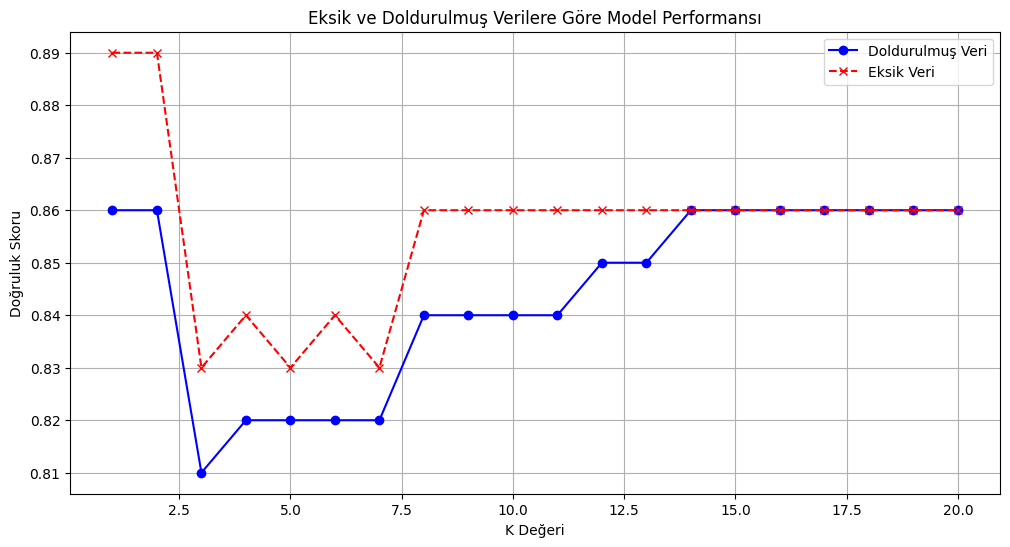

In [253]:

# Grafik Karşılaştırma: Doldurulmuş veri ile eksik verinin doğruluk skorlarını karşılaştıran bir grafik oluşturuyorum
plt.figure(figsize=(12, 6))  # Grafik boyutlarını ayarlıyorum
 # Doldurulmuş verinin doğruluk skorlarını mavi renkte çiziyorum
plt.plot(k_values_fill, acc_scores_fill, marker='o', linestyle='-', color='b', label="Doldurulmuş Veri") 
 # Eksik verinin doğruluk skorlarını kırmızı renkte çiziyorum
plt.plot(k_values_no_fill, acc_scores_no_fill, marker='x', linestyle='--', color='r', label="Eksik Veri") 
plt.title('Eksik ve Doldurulmuş Verilere Göre Model Performansı')  # Grafik başlığını ekliyorum
plt.xlabel('K Değeri')  # x eksenine K değerini etiketliyorum
plt.ylabel('Doğruluk Skoru')  # y eksenine doğruluk skorunu etiketliyorum
plt.legend()  # Grafikteki çizgeleri açıklamak için legend ekliyorum
plt.grid(True)  # Grafik üzerine ızgara ekliyorum
plt.show()  # Grafiği gösteriyorum


<h3>Matrikler</h3>

In [254]:

k_values = list(range(1,21))

#Modeli değerlerndirme
results = evaluate_model_with_metrics(X_train_fill, X_test_fill,y_train_fill, y_test_fill,k_values)

Model evaluation took 9.35 seconds.


In [272]:
# sonuçları yazdır
results_df = pd.DataFrame(results)
print(results_df)

    k_values  accuracy  silhouette  homogeneity  completeness  v_measure  \
0          1      0.86       -0.09         0.06          0.11       0.08   
1          2      0.86       -0.09         0.06          0.11       0.08   
2          3      0.81       -0.01         0.02          0.04       0.03   
3          4      0.82       -0.07         0.02          0.04       0.02   
4          5      0.82       -0.07         0.02          0.04       0.02   
5          6      0.82       -0.07         0.02          0.04       0.02   
6          7      0.82       -0.07         0.02          0.04       0.02   
7          8      0.84        0.04         0.01          0.03       0.01   
8          9      0.84        0.04         0.01          0.03       0.01   
9         10      0.84        0.04         0.01          0.03       0.01   
10        11      0.84        0.04         0.01          0.03       0.01   
11        12      0.85       -0.00         0.00          0.03       0.01   
12        13

**Ağırlıklı KNN Uygulaması**

In [256]:


# Ağırlıklı KNN sınıfı
class WeightedKNN:
    def __init__(self, k=3, metric='euclidean'):
        """
        Sınıfı başlatır.
        :param k: En yakın k komşusunu belirler. Varsayılan olarak 3.
        :param metric: Mesafe metriğini seçer ('euclidean', 'manhattan', 'minkowski').
        """
        self.k = k
        self.metric = metric

    def fit(self, X_train, y_train):
        """
        Eğitim verilerini modelle ilişkilendirir.
        :param X_train: Eğitim verisi özellikleri (n örnek x m özellik).
        :param y_train: Eğitim verisi etiketleri (n örnek).
        """
        self.X_train = X_train_fill
        self.y_train = y_train_fill

    def _compute_distance(self, x1, x2):
        """
        İki nokta arasındaki mesafeyi hesaplar.
        :param x1: İlk nokta.
        :param x2: İkinci nokta.
        :return: İki nokta arasındaki mesafe.
        """
        if self.metric == 'euclidean':  # Öklidyen mesafesi
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.metric == 'manhattan':  # Manhattan mesafesi
            return np.sum(np.abs(x1 - x2))
        elif self.metric == 'minkowski':  # Minkowski mesafesi
            p = 3  # Minkowski metriği için p parametresi
            return np.sum(np.abs(x1 - x2) ** p) ** (1 / p)

    def predict(self, X_test):
        """
        Test verisi için tahminler yapar.
        :param X_test: Test verisi özellikleri (n örnek x m özellik).
        :return: Tahmin edilen etiketler (n örnek).
        """
        predictions = []  # Tahminleri saklamak için bir liste
        for x in X_test:  # Her test örneği için
            # Eğitim verisindeki tüm noktalar ile mesafeleri hesapla
            distances = [self._compute_distance(x, x_train) for x_train in self.X_train]

            # Mesafelere göre en yakın k komşunun indekslerini al
            k_indices = np.argsort(distances)[:self.k]  
            
            # En yakın k komşunun etiketlerini al
            k_labels = [self.y_train[i] for i in k_indices]
            
            # En yakın k komşunun mesafelerini al
            k_distances = [distances[i] for i in k_indices]
            
            # Ağırlıklı oylama için bir sözlük oluştur
            weighted_votes = {}
            for label, dist in zip(k_labels, k_distances):
                # Mesafeye ters orantılı ağırlık hesapla
                weight = 1 / (dist + 1e-5)  # Mesafenin 0 olmasını önlemek için küçük bir sabit eklenir
                if label not in weighted_votes:  # Etiket henüz eklenmediyse
                    weighted_votes[label] = 0
                weighted_votes[label] += weight  # Ağırlığı ekle
            
            # En yüksek ağırlığa sahip etiketi seç ve tahmine ekle
            predictions.append(max(weighted_votes, key=weighted_votes.get))
        
        return predictions  # Tüm tahminler döndürülür



In [257]:
# K değerlerini belirleme
k_values = range(1, 21)

# Doğruluk değerlerini saklamak için listeler
accuracies_standard = []
accuracies_weighted = []


In [258]:
# Her bir k değeri için doğruluk hesaplaması yapıyoruz
for k in k_values:
    # Standart KNN oluşturuluyor
    # 'CustomKNN' sınıfımızı kullanarak k-komşu sayısını ve mesafe ölçütünü (euclidean) belirliyoruz
    standard_knn = CustomKNN(k=k, metric='euclidean')
    # Eğitim verisini modele tanıtıyoruz
    standard_knn.fit(X_train_fill, y_train_fill)
    # Test verisi üzerinden tahminler yapıyoruz
    y_pred_standard = standard_knn.predict(X_test_fill)
    # Tahminlerin doğruluğunu test etiketleriyle karşılaştırarak hesaplıyoruz
    accuracy_standard = accuracy_score(y_test_no_fill, y_pred_standard)
    # Elde edilen doğruluk skorunu Standart KNN sonuçlarına ekliyoruz
    accuracies_standard.append(accuracy_standard)

    # Ağırlıklı KNN oluşturuluyor
    # 'WeightedKNN' sınıfımız k'ya göre ağırlıklandırılmış bir KNN modeli oluşturuyor
    weighted_knn = WeightedKNN(k=k, metric='euclidean')
    # Eğitim verisini modele tanıtıyoruz
    weighted_knn.fit(X_train_fill, y_train_fill)
    # Test verisi üzerinden tahminler yapıyoruz
    y_pred_weighted = weighted_knn.predict(X_test_fill)
    # Tahminlerin doğruluğunu test etiketleriyle karşılaştırarak hesaplıyoruz
    accuracy_weighted = accuracy_score(y_test_fill, y_pred_weighted)
    # Elde edilen doğruluk skorunu Ağırlıklı KNN sonuçlarına ekliyoruz
    accuracies_weighted.append(accuracy_weighted)


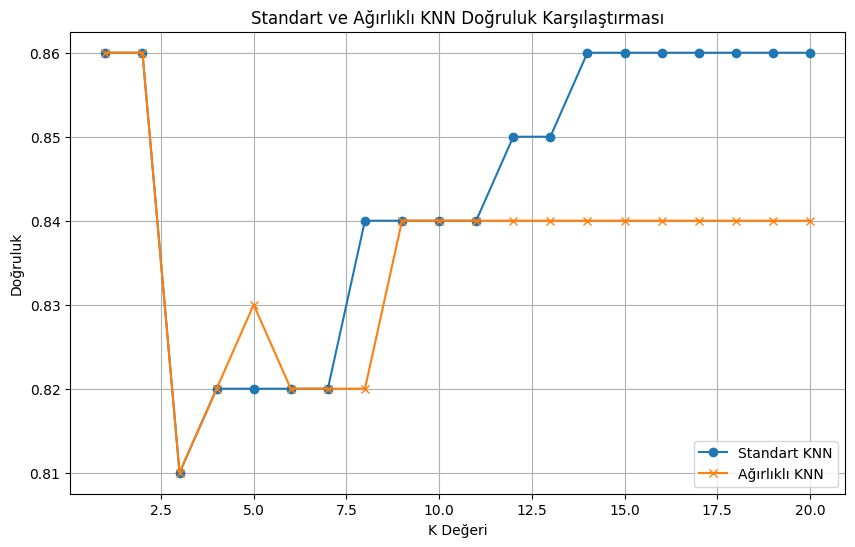

In [259]:


# Grafik oluşturma
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies_standard, label='Standart KNN', marker='o')
plt.plot(k_values, accuracies_weighted, label='Ağırlıklı KNN', marker='x')
plt.xlabel('K Değeri')
plt.ylabel('Doğruluk')
plt.title('Standart ve Ağırlıklı KNN Doğruluk Karşılaştırması')
plt.legend()
plt.grid(True)
plt.show()


*Çoklu Mesafe Metrikleri ile Deneyler*

In [260]:
# Çoklu Mesafe Metrikleri ile Deneyler
metrics = ['euclidean', 'manhattan', 'minkowski']
accuracies = {metric: [] for metric in metrics}

# k değerini 1'den 20'ye kadar deneyin
k_values = range(1, 21)


In [261]:
# Farklı mesafe ölçütleri ve k değerleri için doğruluk hesaplamalarını yapıyoruz
for metric in metrics:
    # K değerini belirleyip, her bir mesafe ölçütü için KNN modeli oluşturuyoruz
    for k in k_values:
        # KNN modeli, k komşusu ve belirtilen mesafe ölçütü ile oluşturuluyor
        knn = CustomKNN(k=k, metric=metric)
        # Eğitim verisini modele tanıtıyoruz
        knn.fit(X_train_fill, y_train_fill)
        # Test verisi üzerinden tahminler yapıyoruz
        y_pred = knn.predict(X_test_fill)
        # Tahminlerin doğruluğunu test etiketleriyle karşılaştırarak hesaplıyoruz
        accuracy = accuracy_score(y_test_fill, y_pred)
        # Hesaplanan doğruluk değerini, ilgili mesafe ölçütü altında saklıyoruz
        accuracies[metric].append(accuracy)




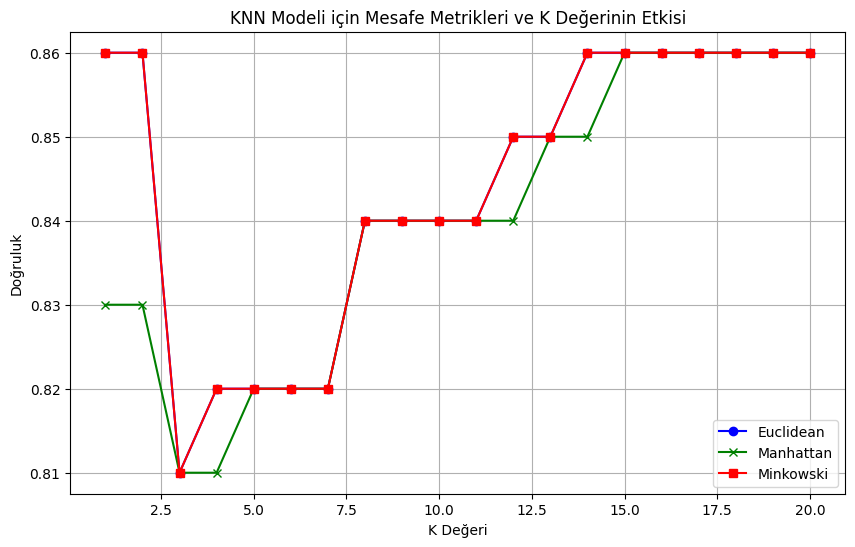

In [262]:
# Sonuçları görselleştirmek için bir grafik oluşturuyoruz
plt.figure(figsize=(10, 6))  # Grafik boyutlarını ayarlıyoruz

# Her mesafe metriği için doğrulukları çizme
plt.plot(k_values, accuracies['euclidean'], label='Euclidean', color='b', marker='o')
plt.plot(k_values, accuracies['manhattan'], label='Manhattan', color='g', marker='x')
plt.plot(k_values, accuracies['minkowski'], label='Minkowski', color='r', marker='s')

# Grafik etiketleri ve başlık
plt.title('KNN Modeli için Mesafe Metrikleri ve K Değerinin Etkisi')
plt.xlabel('K Değeri')
plt.ylabel('Doğruluk')
plt.legend()

# Grafik gösterimi
plt.grid(True)
plt.show()



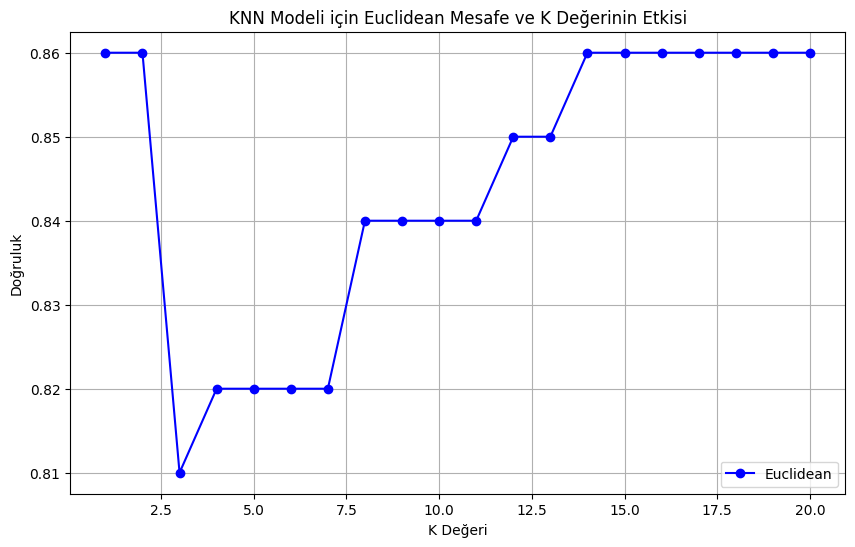

In [263]:
# Euclidean Mesafe Metriki ile Deneyler
# Bu liste, her bir k değeri için hesaplanan doğrulukları tutacaktır
accuracies = []

# k değerini 1'den 20'ye kadar deneyin
# KNN modelinde komşu sayısı (k) 1'den 20'ye kadar değiştirilecektir
k_values = range(1, 21)

# k_values üzerinde döngü başlatıyoruz
for k in k_values:
    # Euclidean mesafe metriği ile KNN modeli oluşturuluyor
    knn = CustomKNN(k=k, metric='euclidean')
    # Model, eğitim verisiyle eğitiliyor
    knn.fit(X_train_fill, y_train_fill)
    # Test verisi üzerinde tahminler yapıyoruz
    y_pred = knn.predict(X_test_fill)
    # Doğruluğu hesaplıyoruz
    accuracy = accuracy_score(y_test_fill, y_pred)
    # Doğruluk değerini accuracies listesine ekliyoruz
    accuracies.append(accuracy)

# Sonuçları grafikleştirme
# Grafik boyutlarını belirliyoruz
plt.figure(figsize=(10, 6))

# Euclidean doğruluklarını çiziyoruz
# x ekseninde k_values, y ekseninde ise doğruluklar olacak
plt.plot(k_values, accuracies, label='Euclidean', color='b', marker='o')

# Grafik etiketleri ve başlık
# Grafik başlığını ve eksen etiketlerini belirliyoruz
plt.title('KNN Modeli için Euclidean Mesafe ve K Değerinin Etkisi')
plt.xlabel('K Değeri')
plt.ylabel('Doğruluk')

# Grafik üzerinde bir açıklama (legend) ekliyoruz
plt.legend()

# Grafik üzerinde ızgara çizgilerini gösteriyoruz
plt.grid(True)

# Grafiği gösteriyoruz
plt.show()


**Aykırı Değer Eklenmesi**

In [264]:
# Aykırı değerler ekliyorum
outlier_indices = np.random.choice(df.index, size=5, replace=False)
df.loc[outlier_indices, 'Gelir'] = df['Gelir'].mean() * 5  # Gelir için aykırı değerler
df.loc[outlier_indices, 'Yaş'] = df['Yaş'].mean() + 50  # Yaş için aykırı değerler

In [265]:

# Aykırı değerleri belirlemek için Z-skor yöntemi kullanıyoruz
def detect_outliers(df, threshold=3):
    # Z-skor hesaplama: Her bir veri noktasından ortalama çıkarılıp, standart sapmaya bölünür
    # Bu işlem her bir özelliğin (sütunun) z-skorunu hesaplar
    z_scores = (df - df.mean()) / df.std()
    
    # Z-skorları belirli bir eşik (threshold) değerini aşarsa, aykırı değer olarak işaretlenir
    # Burada threshold, genellikle 3 kullanılır (z-skoru 3'ten büyük olan değerler aykırı kabul edilir)
    return (np.abs(z_scores) > threshold).any(axis=1)


In [266]:
# Aykırı değerleri belirleme
outlier_mask = detect_outliers(df[['Yaş', 'Gelir']])
df_outliers = df[outlier_mask]  # Aykırı değerler
df_cleaned = df[~outlier_mask]  # Aykırı değerler temizlenmiş veri seti

In [267]:
# Model performansı için bağımsız ve bağımlı değişkenleri ayırıyorum
X = df.drop("Segment", axis=1).values
y = df["Segment"].values
X_cleaned = df_cleaned.drop("Segment", axis=1).values
y_cleaned = df_cleaned["Segment"].values

In [268]:
# Veri setlerini eğitim ve test olarak ayırıyorum
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_cleaned, y_cleaned, test_size=0.2, random_state=42
)


In [269]:
# Modeli değerlendirme fonksiyonunu çağırıyorum
k_values_full, acc_scores_full = evaluate_model(X_train, X_test, y_train, y_test, "Tüm Veri")
k_values_cleaned, acc_scores_cleaned = evaluate_model(
    X_train_clean, X_test_clean, y_train_clean, y_test_clean, "Temizlenmiş Veri"
)

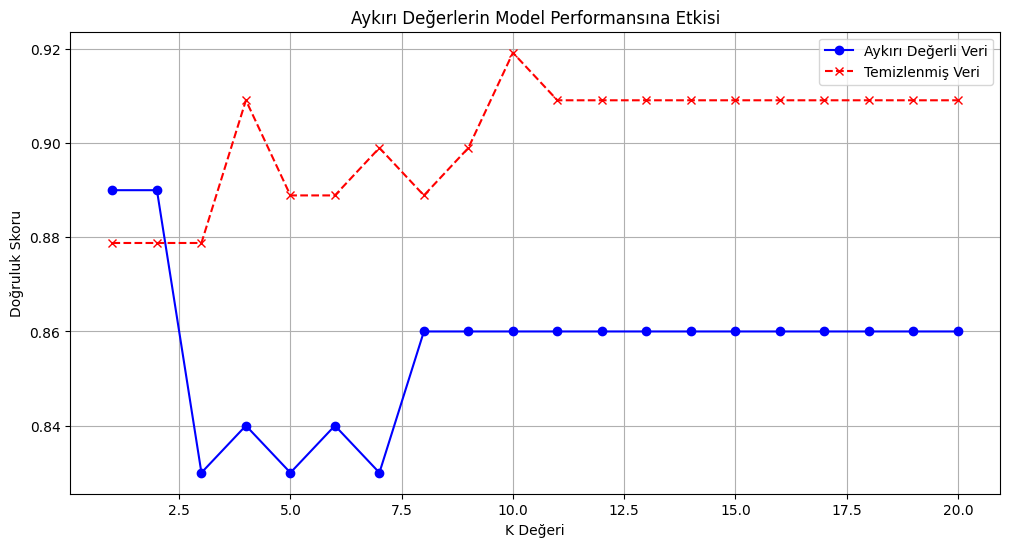

In [270]:

# Performansı karşılaştırıyorum
plt.figure(figsize=(12, 6))
plt.plot(k_values_full, acc_scores_full, marker='o', linestyle='-', color='b', label="Aykırı Değerli Veri")
plt.plot(k_values_cleaned, acc_scores_cleaned, marker='x', linestyle='--', color='r', label="Temizlenmiş Veri")
plt.title('Aykırı Değerlerin Model Performansına Etkisi')
plt.xlabel('K Değeri')
plt.ylabel('Doğruluk Skoru')
plt.legend()
plt.grid(True)
plt.show()



<h1>Matrikler</h1>

<ul>
    <li> time
        <ul>
            <li>
                Algoritmanın çalışması için geçen süreyi gösterir
            </li>
        </ul>
    </li>
    <li> inertia
        <ul>
            <li>
                Kümeleme sonucunda kümeler içindeki veri     noktalarının merkezlerine olan toplam uzaklıkların bir ölçüsüdür .
                Daha düşük bir değer, kümelerin daha sıkı olduğunu ifade eder
            </li>
        </ul>
    </li>
    <li> homo(Homojenlik)
        <ul>
            <li>
                Kümelerin, aynı sınıftan olan veri noktalarını ne kadar iy iaraya getirdiğini ölçer. 1'e ne kadar yakın ise o kadar iyi bir homojenlik sağlar
            </li>
        </ul>
    </li>
    <li> compl(tutarlılık)
        <ul>
            <li>
                Kümelerin farklı sınıflara ait veri noktalarını ne kada iyi ayırdığını ölçer. !' e yakın değerler daha iyidir.
            </li>
        </ul>
    </li>
    <li> v-meas
        <ul>
            <li>
                Homojenlik ve tutarlılık arasında dengeli bir ölçütür. 1'e yakın değerler daha dengeli bir kümeleme anlamına gelir.
            </li>
        </ul>
    </li>
    <li>ARI
        <ul>
            <li>
                Kümelerin yerleşiminin, grafik sınıflandırma ile ne kadar benzer olduğunu ölçer. 1' e yakın olması iyidir.
            </li>
        </ul>
    </li>
    <li> AMI
        <ul>
            <li>
                Gerçek sınıflandırma ile kümeleme sonucu arasındaki karşılıklı bilgi miktarını ölçer. 1' e yakın değerler daha  iyi eşleşme gösterir.
            </li>
        </ul>
    </li>
    <li>silhouette
        <ul>
            <li>
                Veri noktalarının  küme içi tutarlılığı ile kümeler arası ayrımı değerlendiren bir ölçütür . -1 ile 1 arasında değer alır, yüksek değerler daha iyi kümelenmeyi ifade eder
            </li>
        </ul>
    </li>
</ul>